In [2]:
import os, sys, pathlib
base_path = 'C:/Users/marcel.zoll/Documents/repo/tfs_marzol/Marcel/pythonize'
projects = ['Sklearning']

for p in projects:
    sys.path.insert(0, os.path.join(base_path, p, "python"))

In [3]:
'''
simplistic example showing how to use the modules contained in sklearnext
'''


#import sys, os, pathlib
#sys.path.insert(0, str(pathlib.Path(os.getcwd()).parents[1] / 'python'))

#some basic imports
import sys, os, copy
import numpy as np
import datetime as dt
import pandas as pd

In [4]:
#=========================================================================
# construct a dataset with some observations and all kind of mixed lables
#=========================================================================

#--- define the sample size
nObs = 10000

#--- create a observation matrix
idx = np.array(list(range(nObs))) + 1000
c0 = np.array(np.random.choice(['A','B'], size=int(nObs*0.8)).tolist() + ['A']*int(nObs*0.2) )

c1_h = np.random.choice([12,13,14], size=nObs)
c1_d = np.random.choice([0,1], size=nObs)
c1_s = np.random.randint(60, size=nObs)

c1 = []
for i in range(nObs):
    c1.append( dt.datetime(2017,1,1,0,0,0) + dt.timedelta(days=int(c1_d[i]), hours=int(c1_h[i]), minutes=int(c1_s[i])) )

c2 = np.random.choice(['a','b','c'], size=nObs)
c3 = np.round(np.random.rand(nObs), 2)

X = pd.DataFrame({'Device': c0,
             'Time': c1,
             'Label':c2,
             'Cont':c3}, index = idx)

print(X.shape, X.columns)

#--- create a results vector
class xthelper():
    j = 0
    def __int__(self):
        pass
    def __call__(self, row):
        dev_dict = {'A':0.3, 'B':0.8}
        label_dict = {'a':0.8, 'b':0.6, 'c':0.7}
        prob =  ( 0.5 + 0.1*c1_d[self.j] - (c1_h[self.j]-12)*0.5 ) * label_dict[row['Label']] + (row['Cont']-0.5)/4
        prob = max(min(1.,prob), 0.)

        self.j+=1
        if row['Device'] == 'A':
            return int(prob>0.3)
        else:
            return int(prob>0.5)
    
y= X.apply(xthelper(), axis=1)

print(y.shape, "coverage %f" % (np.sum(y)/y.shape[0]))

#split up dataset into train and (held out)test sample
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10000, 4) Index(['Cont', 'Device', 'Label', 'Time'], dtype='object')
(10000,) coverage 0.176500
(8000, 4) (8000,) (2000, 4) (2000,)


In [5]:
#======================
# PIPELINE ASSEMBLY
#======================
from sklearnext.assembly import *
from sklearnext.sklearning.gdbtree_learner import *
from sklearnext.sklearning.oneprob_Classifier import *
from sklearnext.learning.learner import *
from sklearnext.transformers.general import *

#assemble the pipeline by bits an pieces

#OneHot/Label encoding for feature 'Label'
tf0 = TransformerPipe([
        ('pagehistExtr', ColumnsSelect(['Label'])),
        ('labelEnc', LabelDummyTransformer())
    ])

#Extraction of Hour and Day-of-Month fromfeature  'Time'
tf1 = TransformerPipe([
        ('starttimeExtr', ColumnsSelect('Time')),
        ('hwdmyExtr', HourWeekdayDayMonthYearTransformer()),
        ('hwdselect', ColumnsSelect(['Time_hour', 'Time_day']))
    ])

#assemble a set of to use features
fu = FeatureUnion([
        ('tf0', tf0),
        ('tf1', tf1),
        ('tf2', ColumnsSelect('Cont')) # feature 'Cont' could have been wrapped into its own pipeline,
                                       # but no need to convolute as already in correct format
    ], n_jobs= 1)

#define a Classifier estimator; here one that is smarter as the average by growing additional trees
skl_c0 = GrowingGBClassifier(ntrees_start = 100,
            ntress_increment = 10,
            est_params = {'max_depth': 3,
                          'max_features': None}, #auto
            scoring = 'log_loss', #binary_roc_auc
            min_score_improvement = 1e-5,
            nrounds_noimp = 2,
            nrounds_stop = sys.maxsize,
            cv_test_frac = 0.2, 
            cv_n_splits = 3)
                      
#as we are interested in the probabilities rather than the absolute binary classification use this shim
skl_cc0 = OneProbClassifierWrapper(skl_c0, predictClass=1)

# as OneProbClassifier (and GrowingGBClassifier) are using the sklearn interface, make them pandas compatible
cc0 = SklearnerWrapper(skl_cc0)

#this is a complete pipeline, which uses all features except 'Device'
pred_pipe = Pipeline([
        ("fu",fu),
        ("cc0", cc0)
    ])

#make a categorical fork for the feature Device, which has two levels
cf = CategoryFork(pred_pipe,
                  'Device',
                  [('A'),('B')],
                  n_jobs=1 )

#define this by an alias
main_pipe = cf

In [7]:
#=============================
# Train, Verify and Quantisize the model
#=============================

#--- train the pipeline
main_pipe.fit(X_train, y_train)

copy init
done
group done
fit
shapes  (4732, 6) (4732,)
resetting estimator to null-state
call from <sklearnext.sklearning.gdbtree_learner.growing_gdbclassifier object at 0x0000022456905358>
round n_est meter
0 100 -0.010778
1 110 -0.008739
2 120 -0.007156
3 130 -0.005973
4 140 -0.004978
5 150 -0.004280
6 160 -0.003525
7 170 -0.002935
8 180 -0.002443
9 190 -0.002077
10 200 -0.001720
11 210 -0.001448
12 220 -0.001175
13 230 -0.000962
14 240 -0.000786
15 250 -0.000628
16 260 -0.000514
17 270 -0.000418
18 280 -0.000366
19 290 -0.000299
20 300 -0.000245
21 310 -0.000226
22 320 -0.000226
23 330 -0.000226
no improvement for 2 rounds
With 310 estimators:: TrainScore(cv-test): -0.000226 , TrainScore(all): -0.000088
shapes  (3268, 6) (3268,)
resetting estimator to null-state
call from <sklearnext.sklearning.gdbtree_learner.growing_gdbclassifier object at 0x0000022456C7C5F8>
round n_est meter
0 100 -0.001979
1 110 -0.001624
2 120 -0.001406
3 130 -0.001194
4 140 -0.001121
5 150 -0.001048
6 160 -0

In [ ]:
y_test_pred = main_pipe.predict(X_test)
y_train_pred = main_pipe.predict(X_train)
#--- verify the model
from sklearnext.metric import *
ClassifierOvertrainCheck(y_test, y_test_pred, y_train, y_train_pred)

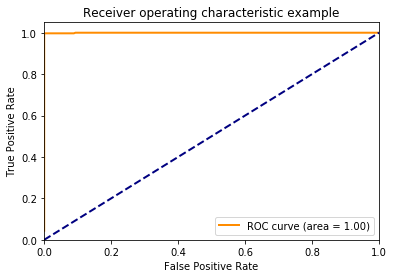

In [16]:
from sklearnext.visualization.viz import plot_BinaryRocAucCurve
plot_BinaryRocAucCurve(y_test, y_test_pred)

In [9]:
#--- have a look at the most important features for each pipeline
fi_deep = cf.get_feature_importances_deep()
print(fi_deep)

fi = cf.get_feature_importances()
print(fi)

RocAuc score :: train: 0.999732  test: 1.000000  diff: -2.675408e-04
LogLoss :: train: 0.005546  test: 0.000083  diff: 5.463386e-03
Adapted LogLoss :: train: -0.450340  test: -0.468456  diff: 1.811557e-02
[('tf0__Label_c', [0.087697168674155807, 0.065989965294359451]), ('tf1__Time_hour', [0.44242535689676105, 0.37825823850859647]), ('tf0__Label_a', [0.073778666221666067, 0.038820425490645558]), ('tf2__Cont', [0.27779648824353564, 0.33804923997619274]), ('tf0__Label_b', [0.048358078265825617, 0.040947817552349164]), ('tf1__Time_day', [0.069944241698055715, 0.13793431317785609])]
[('tf0__Label_c', 0.078829776093508996), ('tf1__Time_hour', 0.41621308903519583), ('tf0__Label_a', 0.059498224883044189), ('tf2__Cont', 0.30240973732632603), ('tf0__Label_b', 0.045330986764370487), ('tf1__Time_day', 0.097718185897554169)]


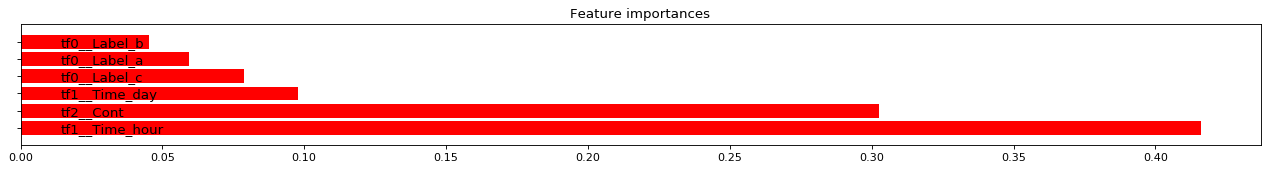

In [10]:
#--- plot the feature importances
from sklearnext.visualization.viz import *
plot_FeatureImportances(main_pipe)

A 0.5915
B 0.4085


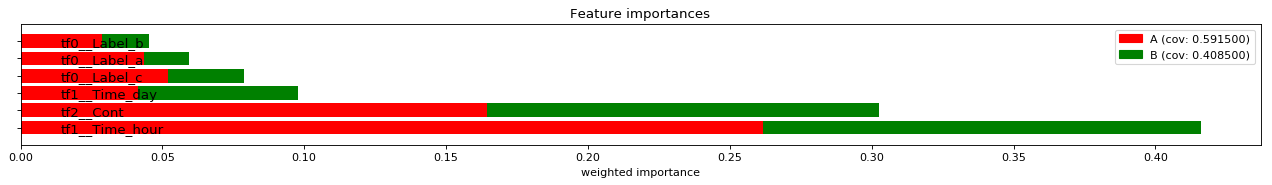

In [11]:
plot_CategoryFork_FeatureImportances(main_pipe, coverage_weighted=True)

A 0.5915
B 0.4085


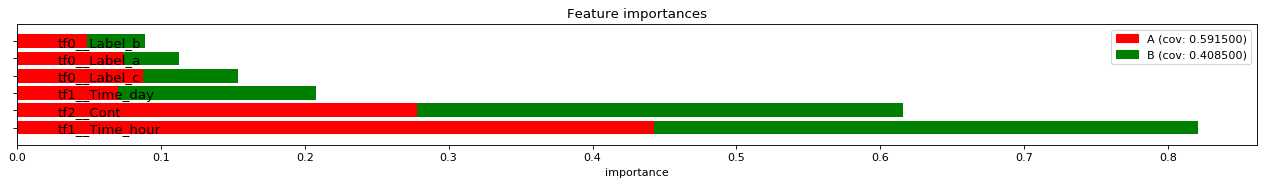

In [12]:
plot_CategoryFork_FeatureImportances(main_pipe, coverage_weighted=False)

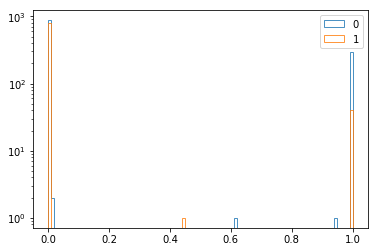

In [15]:
plot_CategoryFork_prediction(main_pipe, X_test)

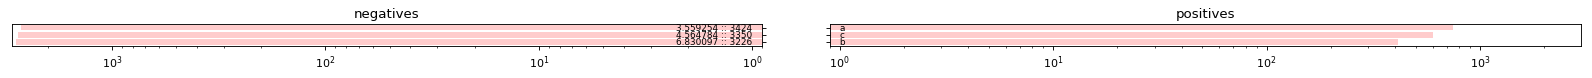

In [14]:
plot_BinaryOutcomeDist(glue(X, y, 'Label'), sys.maxsize)